In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/PNC'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['age_at_cnb'].keys()))
print(len(subs))

1529


In [13]:
import numpy as np

tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
tsdicts = []

for task in ['rest', 'nback', 'emoid']:
    d = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    tsdicts.append(d)

fc = []
age = []
sex = []
race = []
ts = []

for sub in subs:
    for task, td in zip(['rest', 'nback', 'emoid'], tsdicts):
        try:
            p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
            a = demo['age_at_cnb'][sub]
            s = demo['Sex'][sub] == 'M'
            r = demo['Race'][sub] == 'AA'
            age.append(a)
            sex.append(s)
            race.append(r)
            ts.append(td[sub])
            fc.append(p)
        except:
            continue
    
age = np.array(age)
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
fc = np.stack(fc)

print([a.shape for a in [age, sex, race]])
print(len(ts))

[(4319,), (4319,), (4319,)]
4319


In [137]:
# Estimate dynamic connectivity

idcs = np.random.permutation(fc.shape[0])[:1000]
fci = fc[idcs]
agei = age[idcs]
sexi = sex[idcs]
racei = race[idcs]
tsi = [ts[i] for i in idcs]

print(len(tsi))

wsize = 20
dfc = []

for t in tsi:
    dfc.append([])
    for w in range(0,t.shape[-1],wsize):
        p = np.corrcoef(t[:,w:w+wsize])
        dfc[-1].append(p)
        
print('Done')

1000
Done


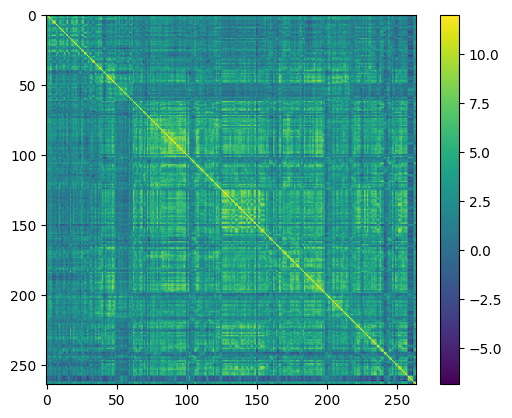

In [142]:
import matplotlib.pyplot as plt

plt.imshow(remap(sum(dfc[3])))
plt.colorbar()
plt.show()

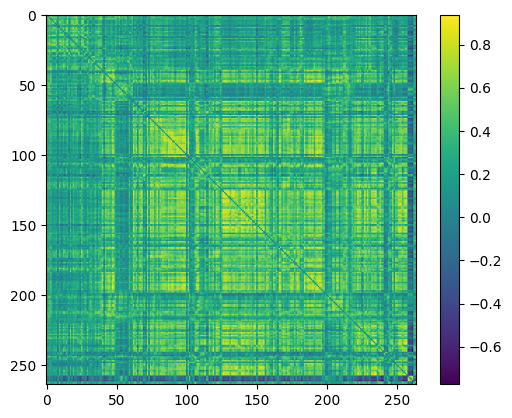

In [143]:
plt.imshow(remap(vec2mat(fci[3])))
plt.colorbar()
plt.show()

In [144]:
a,b = np.triu_indices(264,1)

alldfc = []

for s in dfc:
    for p in s:
        alldfc.append(p[a,b])
        
alldfc = np.stack(alldfc)

print(alldfc.shape)

(10186, 34716)


In [145]:
from sklearn.cluster import KMeans

cls = KMeans(n_clusters=10, n_init='auto').fit(alldfc)

print('Done')

Done


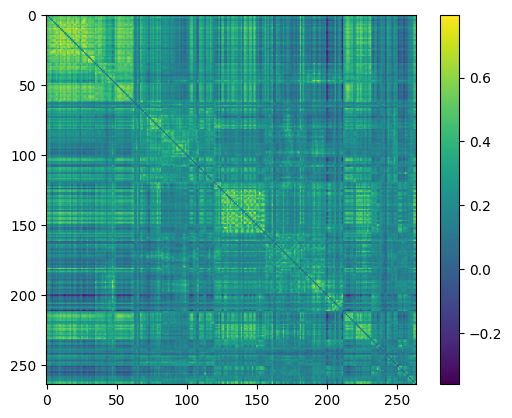

In [147]:
cent = cls.cluster_centers_

plt.imshow(remap(vec2mat(cent[4])))
plt.colorbar()
plt.show()

In [148]:
from sklearn.metrics.pairwise import cosine_similarity

a,b = np.triu_indices(264,1)

cosines = []
ws = []

for j,s in enumerate(dfc):
    avg = cent.shape[0]*[0]
    ws.append(0)
    for p in s:
        w,_,_,_ = np.linalg.lstsq(cent.T, p[a,b], rcond=None)
        ws[-1] += w/len(s)
        for i in range(cent.shape[0]):
            sim = cosine_similarity(cent[i:i+1], np.stack([p[a,b]]))
            avg[i] += sim.squeeze()/len(s)
    cosines.append(avg)
    if j % 10 == 0:
        print(f'Done {j}')
        
print('Complete')
cosines = np.stack(cosines)
ws = np.stack(ws)
print(cosines.shape)
print(ws.shape)

Done 0
Done 10
Done 20
Done 30
Done 40
Done 50
Done 60
Done 70
Done 80
Done 90
Done 100
Done 110
Done 120
Done 130
Done 140
Done 150
Done 160
Done 170
Done 180
Done 190
Done 200
Done 210
Done 220
Done 230
Done 240
Done 250
Done 260
Done 270
Done 280
Done 290
Done 300
Done 310
Done 320
Done 330
Done 340
Done 350
Done 360
Done 370
Done 380
Done 390
Done 400
Done 410
Done 420
Done 430
Done 440
Done 450
Done 460
Done 470
Done 480
Done 490
Done 500
Done 510
Done 520
Done 530
Done 540
Done 550
Done 560
Done 570
Done 580
Done 590
Done 600
Done 610
Done 620
Done 630
Done 640
Done 650
Done 660
Done 670
Done 680
Done 690
Done 700
Done 710
Done 720
Done 730
Done 740
Done 750
Done 760
Done 770
Done 780
Done 790
Done 800
Done 810
Done 820
Done 830
Done 840
Done 850
Done 860
Done 870
Done 880
Done 890
Done 900
Done 910
Done 920
Done 930
Done 940
Done 950
Done 960
Done 970
Done 980
Done 990
Complete
(1000, 10)
(1000, 10)


In [154]:
x0 = ws
x1 = fci
y = sexi #(agei < 14).astype('int')

accs0, accs1 = [], []

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

for _ in range(20):
    xtr0, xt0, xtr1, xt1, ytr, yt = train_test_split(x0, x1, y, stratify=y, train_size=0.8)
    
    reg = LogisticRegression(C=100, max_iter=1000).fit(xtr0, ytr)
    yhat = reg.predict(xt0)
    acc = np.mean(yhat == yt)
    accs0.append(acc)
    s0 = reg.predict_proba(xt0)
    
    print(accs0[-1])
    
#     reg = LogisticRegression(C=1, max_iter=1000).fit(xtr1, ytr)
#     yhat = reg.predict(xt1)
#     acc = np.mean(yhat == yt)
#     accs1.append(acc)
#     s1 = reg.predict_proba(xt1)
    
#     print(accs1[-1])
    
print('---')
[print(np.mean(accs), np.std(accs)) for accs in [accs0]]

0.585
0.595
0.595
0.595
0.625
0.61
0.61
0.6
0.57
0.615
0.525
0.565
0.6
0.57
0.595
0.585
0.605
0.585
0.595
0.54
---
0.58825 0.023836683913665505


[None]

In [22]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
